In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import itertools
from sklearn.preprocessing import StandardScaler
import backtrader as bt
import pyfolio as pf
%matplotlib inline

In [2]:
class BaseStrategy(bt.Strategy):
    
    def __init__(self):
        pass
    
    def next(self):
        pass
    
    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))
        
    def log_candles(self):
        self.log('===>')
        self.log('Current Open: {}, Close: {}'.format(self.data0.open[0],self.data0.close[0]))
        self.log('Next Open: {}, Close: {}'.format(self.data0.open[1],self.data0.close[1]))

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

# Rob Hanna strategy

In [30]:
class TestStrategy(BaseStrategy):
    def __init__(self):
        self.closes_down = self.data0.close < self.data0.open
        self.rsi2_90 = bt.indicators.RSI(self.data0, period=2) > 90
        self.close_200 = self.data0.close > bt.indicators.SimpleMovingAverage(self.data0, period=200)
        
    def next(self):
        if self.position and len(self) >= (self.buy_executed + 2):
            self.sell(exectype=bt.Order.Close)
            self.buy_executed = None
        
        if self.closes_down and self.rsi2_90 and self.close_200:
            self.buy(exectype=bt.Order.Market)
            self.buy_executed = len(self)
            self.log_candles()

In [34]:
cerebro = bt.Cerebro()
cerebro.addstrategy(TestStrategy)

data = bt.feeds.YahooFinanceData(
    dataname='AAPL',
    fromdate=datetime(1995,1,1),
    todate=datetime(2018,1,1),
    reverse=True)

cerebro.adddata(data)
cerebro.broker.setcash(100000.0)
cerebro.broker.setcommission(commission=0.001)
cerebro.broker.set_coc(True)
cerebro.addsizer(bt.sizers.PercentSizer, percents=50)

cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
results = cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

strat = results[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()

Starting Portfolio Value: 100000.00
1995-11-14, ===>
1995-11-14, Current Open: 1.46, Close: 1.32
1995-11-14, Next Open: 1.5, Close: 1.31
1995-11-15, BUY EXECUTED, 1.32
1995-11-17, SELL EXECUTED, 1.28
1996-10-14, ===>
1996-10-14, Current Open: 0.88, Close: 0.81
1996-10-14, Next Open: 0.92, Close: 0.81
1996-10-15, BUY EXECUTED, 0.81
1996-10-15, ===>
1996-10-15, Current Open: 0.92, Close: 0.81
1996-10-15, Next Open: 0.9, Close: 0.82
1996-10-16, Order Canceled/Margin/Rejected
1996-10-16, ===>
1996-10-16, Current Open: 0.9, Close: 0.82
1996-10-16, Next Open: 0.98, Close: 0.84
1996-10-17, Order Canceled/Margin/Rejected
1996-10-17, ===>
1996-10-17, Current Open: 0.98, Close: 0.84
1996-10-17, Next Open: 0.95, Close: 0.85
1996-10-18, Order Canceled/Margin/Rejected
1996-10-18, ===>
1996-10-18, Current Open: 0.95, Close: 0.85
1996-10-18, Next Open: 0.95, Close: 0.82
1996-10-21, Order Canceled/Margin/Rejected
1996-10-23, SELL EXECUTED, 0.79
1996-11-05, ===>
1996-11-05, Current Open: 0.88, Close: 0

Entire data start date: 2002-02-20
Entire data end date: 2017-12-29
Backtest months: 190


,Backtest
Annual return,9.1%
Cumulative returns,298.9%
Annual volatility,8.1%
Sharpe ratio,1.12
Calmar ratio,0.70
Stability,0.95
Max drawdown,-13.1%
Omega ratio,1.49
Sortino ratio,1.87
Skew,1.43


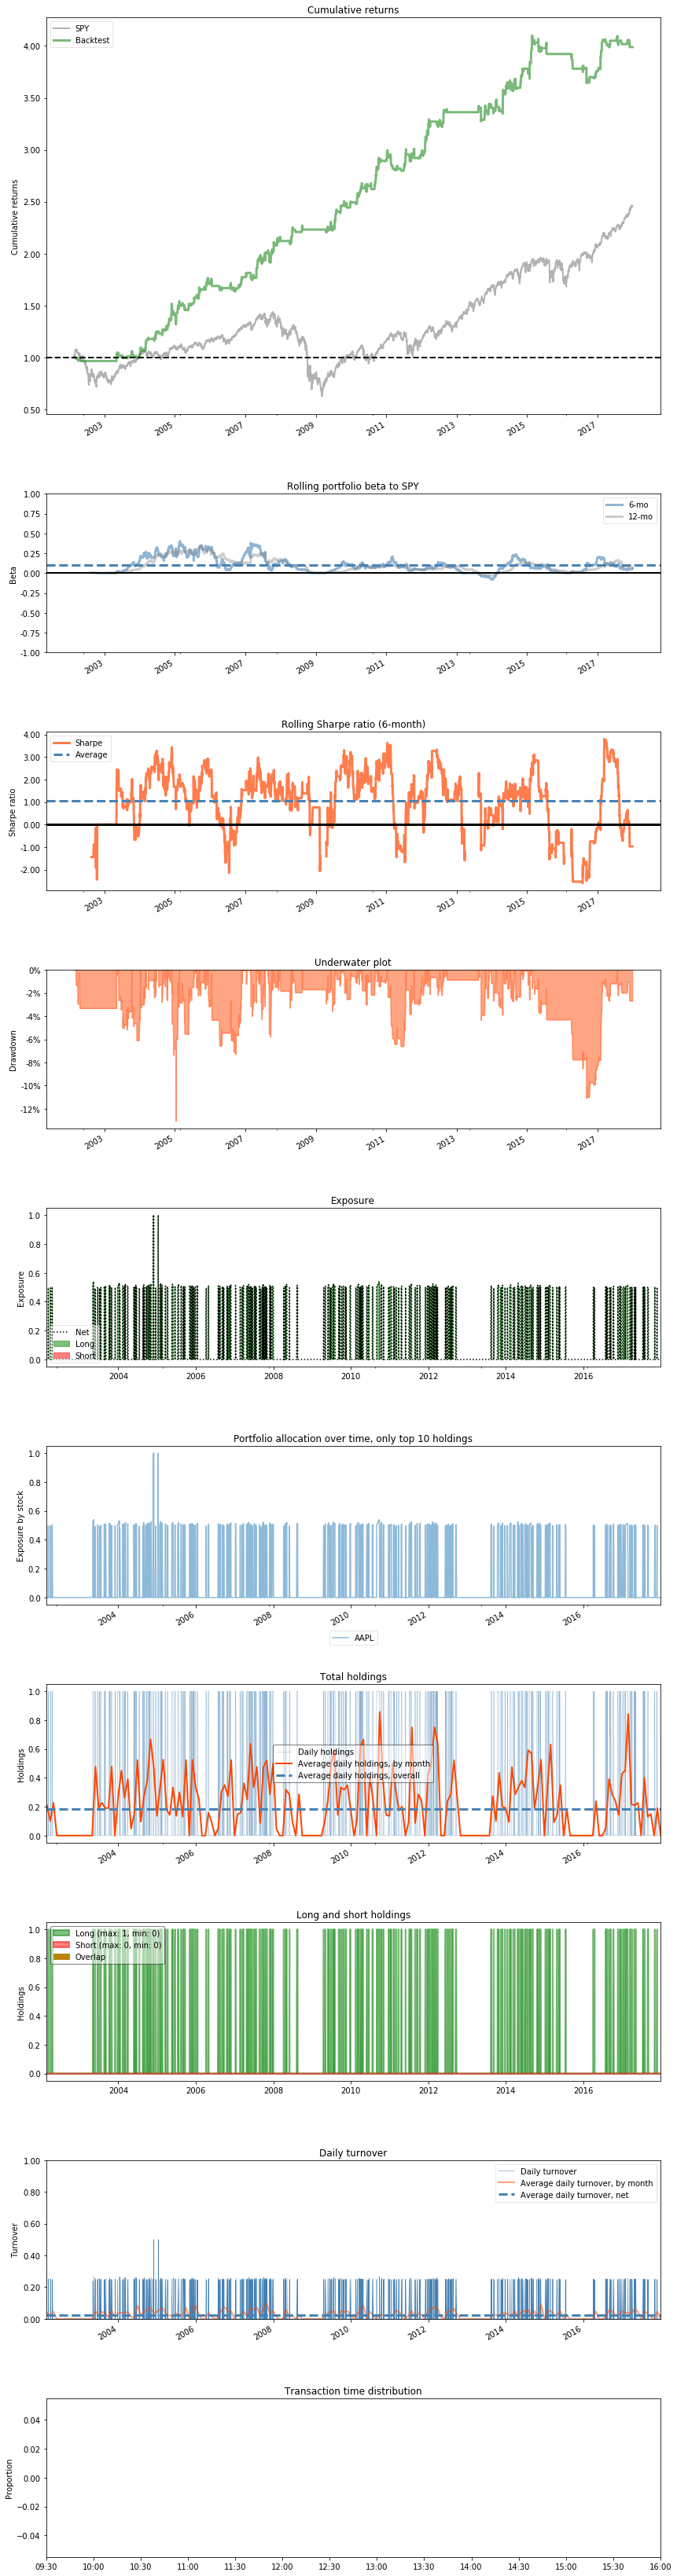

In [35]:
pf.create_simple_tear_sheet(returns=returns, 
                          positions=positions, 
                          transactions=transactions)